# Logistic regression

Here, we are going to predict churn customers using logistic regression and then we are going to evaulate our model using different evaluation matrics.

### Content
1. Loading and cleaning data
2. Class Imbalance
3. Predicting using logistic regression
4. Model evaluation

## 1. Load and cleaning data
<hr>

In [476]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

#### Data importing and preprocessing

In [477]:
# load data from file to existing envrionment
def load_data(filepath,format='csv'):
    if format == 'csv':
        return pd.read_csv(filepath)
    elif format == 'xlsx':
        return pd.read_excel(filepath)

In [334]:
df_raw = load_data("WA_Fn-UseC_-Telco-Customer-Churn.csv","csv")
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [335]:
# Rename column names and map values for numeric calculation
def clean_data(df):
    df.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df['Partner'] = df.Partner.map({'Yes':1,'No':0})
    df['Dependents'] = df.Dependents.map({'Yes':1,'No':0})

    df['PhoneService'] = df.PhoneService.map({'Yes':1,'No':0})
    df['MultipleLines'] = df.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df['InternetService'] = df.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df['OnlineSecurity'] = df.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df['OnlineBackup'] = df.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df['DeviceProtection'] = df.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df['TechSupport'] = df.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingTV'] = df.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df['StreamingMovies'] = df.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})

    df['IsContracted'] = df.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    df['PaperlessBilling'] = df.PaperlessBilling.map({'Yes':1,'No':0})
    df['Churn'] = df.Churn.map({'Yes':1,'No':0})
    
    df.loc[df['TotalCharges']==' ','TotalCharges'] = np.nan
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    df.loc[df['TotalCharges']==np.nan,'TotalCharges'] = df['MonthlyCharges'] * df['Tenure']
    
    return df

In [353]:
# clean, shuffle and reindexing traing data set -- shuffling may improve cross validation accuracy
clean_df = shuffle(clean_data(df_raw.copy())).reset_index()
clean_df.head()

,index,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetServiceType,...,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService,IsContracted
0,3067,7005-CCBKV,Male,0,0,0,6,1,0,Fiber optic,...,0,1,Month-to-month,1,Electronic check,84.40,556.35,1,1,0
1,1215,9897-KXHCM,Female,0,1,1,3,1,0,Fiber optic,...,0,1,Month-to-month,1,Electronic check,80.30,250.05,1,1,0
2,2387,6734-GMPVK,Male,0,0,0,5,1,1,Fiber optic,...,1,1,Month-to-month,0,Electronic check,105.30,550.60,0,1,0
3,1221,3055-MJDSB,Male,0,0,0,9,0,0,DSL,...,0,0,Month-to-month,1,Mailed check,24.60,190.10,0,1,0
4,1473,7079-QRCBC,Female,0,0,0,24,1,1,Fiber optic,...,1,1,Month-to-month,1,Electronic check,98.75,2407.30,1,1,0


In [337]:
# define variables

categorical_vars = ['Gender','InternetServiceType','PaymentMethod','ContractType']
binary_vars = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup'
               ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','PaperlessBilling','InternetService'
               , 'IsContracted']
numeric_vars = ['Tenure','MonthlyCharges']
target_var = 'Churn'

In [338]:
# encode categorical data to numeric using One-hot encoding method
def one_hot_encoding_features_df(df, cat_feat):
    cat_df = pd.get_dummies(df[cat_feat])
    return cat_df


In [339]:
# merge categorical, numerical, and binary data
def merge_df(categorical,binary,numerical):
    return pd.concat([categorical,binary,numerical],axis = 1)


In [340]:
feature_df = merge_df(one_hot_encoding_features_df(clean_df,categorical_vars), clean_df[binary_vars] ,clean_df[numeric_vars])
target_df = clean_df[target_var]

In [400]:
def train_test_split_fn(feature, target , test_size=None, random_state=0):
    return train_test_split(feature, target, test_size = test_size,random_state = random_state )

In [401]:
x_train, x_test, y_train , y_test = train_test_split_fn(feature_df,target_df,test_size=0.2)

## 2. Class Imbalance

<hr>


In [391]:
clean_df.Churn.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Text(0.5,1,'Distribution of churn subs')

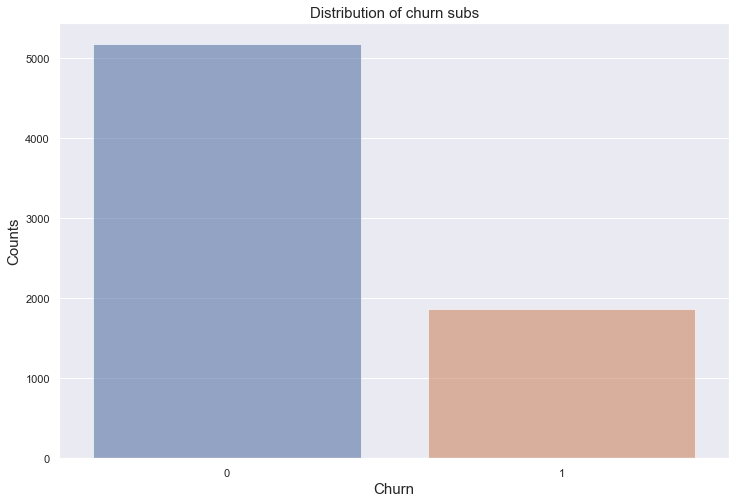

In [397]:
plt.figure(figsize=(12,8))
churn_cnt = clean_df.Churn.value_counts()
sns.barplot(x=churn_cnt.index, y=churn_cnt.values, alpha=0.6)
plt.xlabel("Churn",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.title("Distribution of churn subs",fontsize=15)

### How to treat imbalanced datasets

1. Oversampling - Balance it out by adding more under sample data
2. Undersampling - Balance it out by removing over sample data


#### Methods

- Resample 
    - Up sampling - You randomly resample minority class to create new data
    - Down sampling - You randomly resample majority class to remove some data  
- SMOTE
    - You use nearest neighbors of the minority class to create new synthetic data

In [422]:
# Upsampling using minority class

x_train_us , y_train_us = resample(x_train[y_train == 1]
                                  ,y_train[y_train == 1]
                                  , replace = True  
                                  , n_samples = x_train[y_train == 0].shape[0]
                                  , random_state = 1)

x_train_us = pd.concat([x_train_us, x_train[y_train == 0]], axis = 0)
y_train_us = pd.concat([y_train_us, y_train[y_train == 0]], axis = 0)

#Upsampling using SMOTE
sm = SMOTE(random_state = 12, ratio = 1.0)
x_train_sm , y_train_sm = sm.fit_sample(x_train,y_train)


# Downsampling using majority class
x_train_ds , y_train_ds = resample(x_train[y_train == 0]
                                   , y_train[y_train == 0]
                                   , replace=True
                                   , n_samples = x_train[y_train == 1].shape[0]
                                   , random_state = 1)

x_train_ds = pd.concat([x_train_ds, x_train[y_train == 1]], axis = 0)
y_train_ds = pd.concat([y_train_ds, y_train[y_train == 1]], axis = 0)


print("original shape: ",x_train.shape)
print("Upsampling using resample: ", x_train_us.shape)
print("Upsampling using SMOTE: ", x_train_sm.shape)
print("Downsampling using resample: ",x_train_ds.shape)

original shape:  (5634, 28)
Upsampling using resample:  (8278, 28)
Upsampling using SMOTE:  (8278, 28)
Downsampling using resample:  (2990, 28)


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [433]:
samples = {'original': (x_train, y_train)
          , 'Upsampled': (x_train_us, y_train_us)
          , 'SMOTE': (x_train_sm, y_train_sm)
          , 'Downsampled': (x_train_ds, y_train_ds)}

for sample in samples:
    scores = cross_val_score(LogisticRegression(),samples[sample][0], samples[sample][1], cv=5 , scoring = 'f1')
    print(sample, " : ", scores.mean())
    
    
scores = cross_val_score(LogisticRegression(class_weight='balanced'),x_train, y_train, cv=5 , scoring = 'f1')
print("Original data with balanced characteristic in logistic model  : ", scores.mean())

original  :  0.6022692770004873
Upsampled  :  0.7731396233502524
SMOTE  :  0.7779298713200085
Downsampled  :  0.7778095500934545
Original data with balanced characteristic in logistic model  :  0.6312931990230964


## 3. Predicting using Logistic regression

<hr>

In [467]:
lg_model = LogisticRegression(class_weight='balanced',random_state=42)
lg_model.fit(x_train_sm,y_train_sm)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Calcuate Hard and Soft prediction


    Hard prediction: Using predict() method. Predict 0 or 1
    Soft prediction: Using predict_proba() method. Predict value between 0 and 1

In [468]:
print("Hard predict: \n", lg_model.predict(x_test)[:10])

Hard predict: 
 [1 0 1 1 0 0 0 1 0 1]


In soft prediction

First column predict probability of class - **Not chrun customer**<br>
Second column predict probability of class - **Chrun customer**

In [469]:
print("Soft predict: \n", lg_model.predict_proba(x_test)[:10])

Soft predict: 
 [[0.17048582 0.82951418]
 [0.845022   0.154978  ]
 [0.49426963 0.50573037]
 [0.12854773 0.87145227]
 [0.92897012 0.07102988]
 [0.92548587 0.07451413]
 [0.9184792  0.0815208 ]
 [0.15741718 0.84258282]
 [0.93634131 0.06365869]
 [0.34261488 0.65738512]]


## 4. Model evaluation

<hr>

### Confusion Matrix

- **True positive (TP) : Your prediction that customer churn and s/he is**
- **True negative (TN) : Your prediction that customer churn is not chrun and s/he is not**
- **False positive (FP): Your prediction that customer is churn and s/he is not**
- **False negative (FN): Your prediction that curstomer is not churn and s/he is**


<img src='confusion_matrix.png'></img>

### Classification report

- **Precision** : TP / (TP + FP)
    - Focus on your prediction
    - Measure what fraction of your positive class are valid 
    

- **Recall** : TP / (TP + FN) 
    - Focus on your all positive class
    - How often your predictions actually capture the positive class
    - Also called **Sensitivity or TPR**
    
    
- **F1 score**: Tells you the accuracy of the classifier
    - It calculate using combination of precision and recall. 
  
  
- **Support** : Number of samples of the true response that lies in that class



### Recall or Precision ??

    When want to reduce false negative => Optimize Recall (improve TPR)
        Example : Fraud detection
        
    When want to reduce false positive => Optimize Precision
        Example : Spam vs Non-spam

In our case, we need to **reduce false negative**, because we do not want to miss customers who are going to be churn. So we need to improve **Recall**.

In [470]:
lg_predicted = lg_model.predict(x_test)

# Confusion matrix
metrics.confusion_matrix(y_test,lg_predicted)

## TN , FP 
## FN , TP

array([[771, 264],
       [ 88, 286]], dtype=int64)

In [471]:
# Classification report

print(metrics.classification_report(y_test,lg_predicted))

             precision    recall  f1-score   support

          0       0.90      0.74      0.81      1035
          1       0.52      0.76      0.62       374

avg / total       0.80      0.75      0.76      1409



AUROC (Area under the Receiver Operting Characteristics) is 75%, means 75% of the chances that our model is able to distinguish between positive class and negative class.

In [475]:
print("ROC AUC score: ",metrics.roc_auc_score(y_test, lg_predicted))

ROC AUC score:  0.7548167092924126


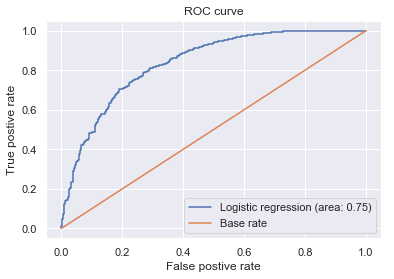

In [474]:
# ROC curve

fpr, tpr, thresold = metrics.roc_curve(y_test, lg_model.predict_proba(x_test)[:][:,1])

plt.plot(fpr,tpr , label = 'Logistic regression (area: %0.2f)' % metrics.roc_auc_score(y_test, lg_predicted))
plt.plot([0,1],[0,1],label = 'Base rate')
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.title("ROC curve")
plt.legend()

In [479]:
rf_result_1 = cross_val_score(LogisticRegression(), x_train_sm, y_train_sm ,cv=5, scoring = 'accuracy')
print(rf_result_1.mean())

0.7714409220218589


## **Optimization**

Here, we tried to predict churn customers using **logistic regression with 75% of the AUROC score**.  However, We want our machine learning model to capture as much of the Churn customers as possible.

Let's try to solve this issue using **Random forest** and **Gradiant Boosting Classifier** model and compared with Logistic regression. Also, let's cross check the features that we explored during EDA process are same as the Random forest will suggest to predict Churn customers.
